In [2]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from IPython.display import HTML
import json
import altair as alt

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline



In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
train = reduce_mem_usage(pd.read_csv('input/train.csv.zip'))
test = reduce_mem_usage(pd.read_csv('input/test.csv.zip'))
mulliken = reduce_mem_usage(pd.read_csv('input/mulliken_charges.csv.zip'))
dipole = reduce_mem_usage(pd.read_csv('input/dipole_moments.csv.zip'))
structure = reduce_mem_usage(pd.read_csv('input/structures.csv.zip'))
potential = reduce_mem_usage(pd.read_csv('input/potential_energy.csv.zip'))
magnetic = reduce_mem_usage(pd.read_csv('input/magnetic_shielding_tensors.csv.zip'))
scaler = reduce_mem_usage(pd.read_csv('input/scalar_coupling_contributions.csv.zip'))
sub = reduce_mem_usage(pd.read_csv('input/sample_submission.csv.zip'))


Mem. usage decreased to 106.62 Mb (50.0% reduction)
Mem. usage decreased to 52.57 Mb (45.0% reduction)
Mem. usage decreased to 16.09 Mb (54.2% reduction)
Mem. usage decreased to  1.13 Mb (56.2% reduction)
Mem. usage decreased to 51.74 Mb (52.1% reduction)
Mem. usage decreased to  0.81 Mb (37.5% reduction)
Mem. usage decreased to 39.49 Mb (69.3% reduction)
Mem. usage decreased to 115.50 Mb (59.4% reduction)
Mem. usage decreased to 11.95 Mb (68.7% reduction)


In [5]:
train.head(10)

id     molecule_name  atom_index_0  atom_index_1  type  \
0   0  dsgdb9nsd_000001             1             0  1JHC   
1   1  dsgdb9nsd_000001             1             2  2JHH   
2   2  dsgdb9nsd_000001             1             3  2JHH   
3   3  dsgdb9nsd_000001             1             4  2JHH   
4   4  dsgdb9nsd_000001             2             0  1JHC   
5   5  dsgdb9nsd_000001             2             3  2JHH   
6   6  dsgdb9nsd_000001             2             4  2JHH   
7   7  dsgdb9nsd_000001             3             0  1JHC   
8   8  dsgdb9nsd_000001             3             4  2JHH   
9   9  dsgdb9nsd_000001             4             0  1JHC   

   scalar_coupling_constant  
0                84.8125000  
1               -11.2578125  
2               -11.2578125  
3               -11.2578125  
4                84.8125000  
5               -11.2578125  
6               -11.2578125  
7                84.8125000  
8               -11.2578125  
9                84.8125000

In [6]:
structure.head()

molecule_name  atom_index atom                 x                  y  \
0  dsgdb9nsd_000001           0    C -0.01269531250000  1.085937500000000   
1  dsgdb9nsd_000001           1    H  0.00214958190918 -0.006031036376953   
2  dsgdb9nsd_000001           2    H  1.01171875000000  1.463867187500000   
3  dsgdb9nsd_000001           3    H -0.54101562500000  1.447265625000000   
4  dsgdb9nsd_000001           4    H -0.52392578125000  1.437500000000000   

                   z  
0  0.008003234863281  
1  0.001976013183594  
2  0.000276565551758  
3 -0.876464843750000  
4  0.906250000000000

In [7]:
# train = train.merge(structure[['x', 'y', 'z', 'molecule_name']], on=['molecule_name'], how='outer')
# test = test.merge(structure[['x', 'y', 'z', 'molecule_name']], on=['molecule_name'], how='outer')

In [8]:
test.shape

(2505542, 5)

In [9]:
y = train['scalar_coupling_constant']

In [15]:
from tqdm import tqdm_notebook as tqdm
atomic_radius = {'H':0.38, 'C':0.77, 'N':0.75, 'O':0.73, 'F':0.71} # Without fudge factor

fudge_factor = 0.05
atomic_radius = {k:v + fudge_factor for k,v in atomic_radius.items()}
print(atomic_radius)

electronegativity = {'H':2.2, 'C':2.55, 'N':3.04, 'O':3.44, 'F':3.98}

#structures = pd.read_csv(structures, dtype={'atom_index':np.int8})

atoms = structure['atom'].values
atoms_en = [electronegativity[x] for x in tqdm(atoms)]
atoms_rad = [atomic_radius[x] for x in tqdm(atoms)]

structure['EN'] = atoms_en
structure['rad'] = atoms_rad


{'H': 0.43, 'C': 0.8200000000000001, 'N': 0.8, 'O': 0.78, 'F': 0.76}


In [10]:
train.head()

id     molecule_name  atom_index_0  atom_index_1  type  \
0   0  dsgdb9nsd_000001             1             0  1JHC   
1   1  dsgdb9nsd_000001             1             2  2JHH   
2   2  dsgdb9nsd_000001             1             3  2JHH   
3   3  dsgdb9nsd_000001             1             4  2JHH   
4   4  dsgdb9nsd_000001             2             0  1JHC   

   scalar_coupling_constant  
0                84.8125000  
1               -11.2578125  
2               -11.2578125  
3               -11.2578125  
4                84.8125000

In [16]:
i_atom = structure['atom_index'].values
p = structure[['x', 'y', 'z']].values
p_compare = p
m = structure['molecule_name'].values
m_compare = m
r = structure['rad'].values
r_compare = r

source_row = np.arange(len(structure))
max_atoms = 28

bonds = np.zeros((len(structure)+1, max_atoms+1), dtype=np.int8)
bond_dists = np.zeros((len(structure)+1, max_atoms+1), dtype=np.float32)

print('Calculating bonds')

for i in tqdm(range(max_atoms-1)):
    p_compare = np.roll(p_compare, -1, axis=0)
    m_compare = np.roll(m_compare, -1, axis=0)
    r_compare = np.roll(r_compare, -1, axis=0)
    
    mask = np.where(m == m_compare, 1, 0) #Are we still comparing atoms in the same molecule?
    dists = np.linalg.norm(p - p_compare, axis=1) * mask
    r_bond = r + r_compare
    
    bond = np.where(np.logical_and(dists > 0.0001, dists < r_bond), 1, 0)
    
    source_row = source_row
    target_row = source_row + i + 1 #Note: Will be out of bounds of bonds array for some values of i
    target_row = np.where(np.logical_or(target_row > len(structure), mask==0), len(structure), target_row) #If invalid target, write to dummy row
    
    source_atom = i_atom
    target_atom = i_atom + i + 1 #Note: Will be out of bounds of bonds array for some values of i
    target_atom = np.where(np.logical_or(target_atom > max_atoms, mask==0), max_atoms, target_atom) #If invalid target, write to dummy col
    
    bonds[(source_row, target_atom)] = bond
    bonds[(target_row, source_atom)] = bond
    bond_dists[(source_row, target_atom)] = dists
    bond_dists[(target_row, source_atom)] = dists

bonds = np.delete(bonds, axis=0, obj=-1) #Delete dummy row
bonds = np.delete(bonds, axis=1, obj=-1) #Delete dummy col
bond_dists = np.delete(bond_dists, axis=0, obj=-1) #Delete dummy row
bond_dists = np.delete(bond_dists, axis=1, obj=-1) #Delete dummy col

print('Counting and condensing bonds')

bonds_numeric = [[i for i,x in enumerate(row) if x] for row in tqdm(bonds)]
bond_lengths = [[dist for i,dist in enumerate(row) if i in bonds_numeric[j]] for j,row in enumerate(tqdm(bond_dists))]
bond_lengths_mean = [ np.mean(x) for x in bond_lengths]
n_bonds = [len(x) for x in bonds_numeric]

#bond_data = {'bond_' + str(i):col for i, col in enumerate(np.transpose(bonds))}
#bond_data.update({'bonds_numeric':bonds_numeric, 'n_bonds':n_bonds})

bond_data = {'n_bonds':n_bonds, 'bond_lengths_mean': bond_lengths_mean }
bond_df = pd.DataFrame(bond_data)
structure = structure.join(bond_df)

Calculating bonds



Counting and condensing bonds


In [18]:
def map_atom_info(df, atom_idx):
    df = pd.merge(df, structure, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    #df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

train = map_atom_info(train, 0)
train = map_atom_info(train, 1)

test = map_atom_info(test, 0)
test = map_atom_info(test, 1)

In [26]:
train.columns

Index(['id', 'molecule_name', 'atom_index_0', 'atom_index_1', 'type',
       'scalar_coupling_constant', 'atom_index_x', 'atom_0', 'x_0', 'y_0',
       'z_0', 'EN_x', 'rad_x', 'n_bonds_x', 'bond_lengths_mean_x',
       'atom_index_y', 'atom_1', 'x_1', 'y_1', 'z_1', 'EN_y', 'rad_y',
       'n_bonds_y', 'bond_lengths_mean_y'],
      dtype='object')

In [20]:
train.shape

(4658147, 24)

In [21]:
np.unique(train['type'])

array(['1JHC', '1JHN', '2JHC', '2JHH', '2JHN', '3JHC', '3JHH', '3JHN'],
      dtype=object)

In [22]:
def metric(df, preds):
    df["prediction"] = preds
    maes = []
    for t in df.type.unique():
        y_true = df[df.type==t].scalar_coupling_constant.values
        y_pred = df[df.type==t].prediction.values
        mae = np.log(metrics.mean_absolute_error(y_true, y_pred))
        maes.append(mae)
    return np.mean(maes)
#df for evaluate
eval_df = pd.DataFrame({"type": train["type"]})
eval_df["scalar_coupling_constant"] = y

In [23]:
train.shape

(4658147, 24)

In [24]:
params = {'num_leaves': 2**4,
          'min_child_samples': 80,
          'objective': 'regression',
          'max_depth': 5,
          'learning_rate': 0.02,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.1,
          'colsample_bytree': 0.65
         }

In [1]:
train_x = pd.read_csv('train_0.csv')

NameError: name 'pd' is not defined

In [27]:
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
n_split = 5
kf = KFold(n_splits=n_split, random_state=666, shuffle=True)
    
for type_ in np.unique(train['type']):

    
    train_ = train[train['type'] == type_]
    test_ = test[test['type'] == type_]
    
    train_index = train_.index
    test_index = test_.index
    
    y_ = y[train['type'] == type_]
    
    features = [c for c in train_.columns if c not in ['id', 'molecule_name',
                                                       'type', 'scalar_coupling_constant',
                                                       'atom_0', 'atom_1']]
#     features = ['atom_index_0', 'atom_index_1']

    for i, (train_idx, valid_idx) in enumerate(kf.split(train_)):  
        print(f'Fold {i + 1}')
        x_train = train_[features]
        y_train = y_
        trn_data = lgb.Dataset(x_train.iloc[train_idx], label=y_train.iloc[train_idx])
        val_data = lgb.Dataset(x_train.iloc[valid_idx], label=y_train.iloc[valid_idx])

        num_round = 100000
        clf = lgb.train(params, trn_data, num_round, valid_sets = [trn_data, val_data],
                        verbose_eval=500, early_stopping_rounds = 100)
        oof[train_index[valid_idx]] = clf.predict(x_train.iloc[valid_idx], num_iteration=clf.best_iteration)

        predictions[test_index] += clf.predict(test_[features], num_iteration=clf.best_iteration) / n_split

    
print("CV score: {:<8.5f}".format(metric(eval_df, oof)))

Fold 1
Training until validation scores don't improve for 100 rounds.
[500]	training's l1: 3.21308	valid_1's l1: 3.21511
[1000]	training's l1: 3.09544	valid_1's l1: 3.09932
[1500]	training's l1: 3.02549	valid_1's l1: 3.03233
[2000]	training's l1: 2.97987	valid_1's l1: 2.99006
[2500]	training's l1: 2.94106	valid_1's l1: 2.95504
[3000]	training's l1: 2.90737	valid_1's l1: 2.9249
[3500]	training's l1: 2.8788	valid_1's l1: 2.89965
[4000]	training's l1: 2.85318	valid_1's l1: 2.87746
[4500]	training's l1: 2.83063	valid_1's l1: 2.85842
[5000]	training's l1: 2.80997	valid_1's l1: 2.84086
[5500]	training's l1: 2.79029	valid_1's l1: 2.82421
[6000]	training's l1: 2.77347	valid_1's l1: 2.81039
[6500]	training's l1: 2.7569	valid_1's l1: 2.79653
[7000]	training's l1: 2.74093	valid_1's l1: 2.78358
[7500]	training's l1: 2.72726	valid_1's l1: 2.77274
[8000]	training's l1: 2.71406	valid_1's l1: 2.76262
[8500]	training's l1: 2.70154	valid_1's l1: 2.75286
[9000]	training's l1: 2.68892	valid_1's l1: 2.7430

[78000]	training's l1: 2.15557	valid_1's l1: 2.44145
[78500]	training's l1: 2.15361	valid_1's l1: 2.4407
[79000]	training's l1: 2.15168	valid_1's l1: 2.43995
[79500]	training's l1: 2.14975	valid_1's l1: 2.4392
[80000]	training's l1: 2.1478	valid_1's l1: 2.43854
[80500]	training's l1: 2.14584	valid_1's l1: 2.43784
[81000]	training's l1: 2.14395	valid_1's l1: 2.43715
[81500]	training's l1: 2.14203	valid_1's l1: 2.43654
[82000]	training's l1: 2.1401	valid_1's l1: 2.4358
[82500]	training's l1: 2.13822	valid_1's l1: 2.43512
[83000]	training's l1: 2.13625	valid_1's l1: 2.43435
[83500]	training's l1: 2.13443	valid_1's l1: 2.43373
[84000]	training's l1: 2.13252	valid_1's l1: 2.43303
[84500]	training's l1: 2.13056	valid_1's l1: 2.43228
[85000]	training's l1: 2.1287	valid_1's l1: 2.43165
[85500]	training's l1: 2.12691	valid_1's l1: 2.43098
[86000]	training's l1: 2.12507	valid_1's l1: 2.43034
[86500]	training's l1: 2.12322	valid_1's l1: 2.42974
[87000]	training's l1: 2.12137	valid_1's l1: 2.42907

[54500]	training's l1: 2.26474	valid_1's l1: 2.48126
[55000]	training's l1: 2.26219	valid_1's l1: 2.48011
[55500]	training's l1: 2.25967	valid_1's l1: 2.47907
[56000]	training's l1: 2.25717	valid_1's l1: 2.47795
[56500]	training's l1: 2.25467	valid_1's l1: 2.47676
[57000]	training's l1: 2.2522	valid_1's l1: 2.47559
[57500]	training's l1: 2.24976	valid_1's l1: 2.47453
[58000]	training's l1: 2.24729	valid_1's l1: 2.47342
[58500]	training's l1: 2.24484	valid_1's l1: 2.4723
[59000]	training's l1: 2.24238	valid_1's l1: 2.47115
[59500]	training's l1: 2.24002	valid_1's l1: 2.47018
[60000]	training's l1: 2.2376	valid_1's l1: 2.4691
[60500]	training's l1: 2.23521	valid_1's l1: 2.468
[61000]	training's l1: 2.23284	valid_1's l1: 2.46697
[61500]	training's l1: 2.23054	valid_1's l1: 2.46608
[62000]	training's l1: 2.22808	valid_1's l1: 2.4649
[62500]	training's l1: 2.22581	valid_1's l1: 2.46396
[63000]	training's l1: 2.22352	valid_1's l1: 2.46294
[63500]	training's l1: 2.22119	valid_1's l1: 2.46194


[31000]	training's l1: 2.40913	valid_1's l1: 2.55762
[31500]	training's l1: 2.40531	valid_1's l1: 2.5556
[32000]	training's l1: 2.40137	valid_1's l1: 2.55342
[32500]	training's l1: 2.39746	valid_1's l1: 2.55124
[33000]	training's l1: 2.39362	valid_1's l1: 2.54909
[33500]	training's l1: 2.39007	valid_1's l1: 2.54719
[34000]	training's l1: 2.38639	valid_1's l1: 2.54532
[34500]	training's l1: 2.38274	valid_1's l1: 2.54346
[35000]	training's l1: 2.37917	valid_1's l1: 2.54168
[35500]	training's l1: 2.37561	valid_1's l1: 2.53988
[36000]	training's l1: 2.37196	valid_1's l1: 2.538
[36500]	training's l1: 2.36847	valid_1's l1: 2.53622
[37000]	training's l1: 2.36502	valid_1's l1: 2.53447
[37500]	training's l1: 2.36149	valid_1's l1: 2.5325
[38000]	training's l1: 2.35811	valid_1's l1: 2.53088
[38500]	training's l1: 2.35481	valid_1's l1: 2.52918
[39000]	training's l1: 2.35133	valid_1's l1: 2.52737
[39500]	training's l1: 2.34806	valid_1's l1: 2.52573
[40000]	training's l1: 2.34477	valid_1's l1: 2.524

[18000]	training's l1: 2.53676	valid_1's l1: 2.63333
[18500]	training's l1: 2.53081	valid_1's l1: 2.62951
[19000]	training's l1: 2.52469	valid_1's l1: 2.62556
[19500]	training's l1: 2.51886	valid_1's l1: 2.62192
[20000]	training's l1: 2.51298	valid_1's l1: 2.61821
[20500]	training's l1: 2.50714	valid_1's l1: 2.61462
[21000]	training's l1: 2.50162	valid_1's l1: 2.61111
[21500]	training's l1: 2.49604	valid_1's l1: 2.60759
[22000]	training's l1: 2.49061	valid_1's l1: 2.60426
[22500]	training's l1: 2.48537	valid_1's l1: 2.60099
[23000]	training's l1: 2.48016	valid_1's l1: 2.59772
[23500]	training's l1: 2.47512	valid_1's l1: 2.59463
[24000]	training's l1: 2.47025	valid_1's l1: 2.59175
[24500]	training's l1: 2.46541	valid_1's l1: 2.58887
[25000]	training's l1: 2.46072	valid_1's l1: 2.58611
[25500]	training's l1: 2.45609	valid_1's l1: 2.58341
[26000]	training's l1: 2.45159	valid_1's l1: 2.58085
[26500]	training's l1: 2.44713	valid_1's l1: 2.57821
[27000]	training's l1: 2.44295	valid_1's l1: 2

[96000]	training's l1: 2.09308	valid_1's l1: 2.41919
[96500]	training's l1: 2.09134	valid_1's l1: 2.41861
[97000]	training's l1: 2.08965	valid_1's l1: 2.41793
[97500]	training's l1: 2.08793	valid_1's l1: 2.41737
[98000]	training's l1: 2.08625	valid_1's l1: 2.4168
[98500]	training's l1: 2.08454	valid_1's l1: 2.4162
[99000]	training's l1: 2.08286	valid_1's l1: 2.41556
[99500]	training's l1: 2.08119	valid_1's l1: 2.415
[100000]	training's l1: 2.07953	valid_1's l1: 2.41445
Did not meet early stopping. Best iteration is:
[100000]	training's l1: 2.07953	valid_1's l1: 2.41445
Fold 5
Training until validation scores don't improve for 100 rounds.
[500]	training's l1: 3.2096	valid_1's l1: 3.22808
[1000]	training's l1: 3.09768	valid_1's l1: 3.11863
[1500]	training's l1: 3.031	valid_1's l1: 3.05471
[2000]	training's l1: 2.98564	valid_1's l1: 3.01257
[2500]	training's l1: 2.94763	valid_1's l1: 2.9778
[3000]	training's l1: 2.91537	valid_1's l1: 2.94894
[3500]	training's l1: 2.88824	valid_1's l1: 2.9

[91000]	training's l1: 2.10989	valid_1's l1: 2.43609
[91500]	training's l1: 2.10812	valid_1's l1: 2.43545
[92000]	training's l1: 2.1063	valid_1's l1: 2.43475
[92500]	training's l1: 2.10453	valid_1's l1: 2.43411
[93000]	training's l1: 2.10281	valid_1's l1: 2.43353
[93500]	training's l1: 2.1011	valid_1's l1: 2.43293
[94000]	training's l1: 2.09942	valid_1's l1: 2.43238
[94500]	training's l1: 2.09763	valid_1's l1: 2.4318
[95000]	training's l1: 2.09593	valid_1's l1: 2.43122
[95500]	training's l1: 2.09418	valid_1's l1: 2.43064
[96000]	training's l1: 2.09251	valid_1's l1: 2.43016
[96500]	training's l1: 2.09086	valid_1's l1: 2.42958
[97000]	training's l1: 2.08915	valid_1's l1: 2.42902
[97500]	training's l1: 2.08751	valid_1's l1: 2.42856
[98000]	training's l1: 2.08581	valid_1's l1: 2.42801
[98500]	training's l1: 2.08407	valid_1's l1: 2.42744
[99000]	training's l1: 2.08243	valid_1's l1: 2.42687
[99500]	training's l1: 2.08076	valid_1's l1: 2.42634
[100000]	training's l1: 2.07905	valid_1's l1: 2.4

[13000]	training's l1: 0.798011	valid_1's l1: 1.02062
[13500]	training's l1: 0.791063	valid_1's l1: 1.0188
[14000]	training's l1: 0.784548	valid_1's l1: 1.01715
[14500]	training's l1: 0.778392	valid_1's l1: 1.01595
[15000]	training's l1: 0.771962	valid_1's l1: 1.01447
[15500]	training's l1: 0.766229	valid_1's l1: 1.01319
[16000]	training's l1: 0.760502	valid_1's l1: 1.01205
[16500]	training's l1: 0.754485	valid_1's l1: 1.01061
[17000]	training's l1: 0.748583	valid_1's l1: 1.00944
[17500]	training's l1: 0.742985	valid_1's l1: 1.00819
Early stopping, best iteration is:
[17833]	training's l1: 0.739428	valid_1's l1: 1.00762
Fold 4
Training until validation scores don't improve for 100 rounds.
[500]	training's l1: 1.27145	valid_1's l1: 1.29456
[1000]	training's l1: 1.16148	valid_1's l1: 1.19613
[1500]	training's l1: 1.10567	valid_1's l1: 1.15097
[2000]	training's l1: 1.06692	valid_1's l1: 1.12187
[2500]	training's l1: 1.03839	valid_1's l1: 1.10301
[3000]	training's l1: 1.01738	valid_1's l1:

[30000]	training's l1: 1.33149	valid_1's l1: 1.38741
[30500]	training's l1: 1.32965	valid_1's l1: 1.38626
[31000]	training's l1: 1.32779	valid_1's l1: 1.38505
[31500]	training's l1: 1.32598	valid_1's l1: 1.38393
[32000]	training's l1: 1.32417	valid_1's l1: 1.38279
[32500]	training's l1: 1.32238	valid_1's l1: 1.38168
[33000]	training's l1: 1.32062	valid_1's l1: 1.38059
[33500]	training's l1: 1.31884	valid_1's l1: 1.37945
[34000]	training's l1: 1.31709	valid_1's l1: 1.37834
[34500]	training's l1: 1.31537	valid_1's l1: 1.37729
[35000]	training's l1: 1.3136	valid_1's l1: 1.37618
[35500]	training's l1: 1.3119	valid_1's l1: 1.37511
[36000]	training's l1: 1.31025	valid_1's l1: 1.37407
[36500]	training's l1: 1.30858	valid_1's l1: 1.37303
[37000]	training's l1: 1.30687	valid_1's l1: 1.37195
[37500]	training's l1: 1.30522	valid_1's l1: 1.37096
[38000]	training's l1: 1.30352	valid_1's l1: 1.36991
[38500]	training's l1: 1.30199	valid_1's l1: 1.36898
[39000]	training's l1: 1.30038	valid_1's l1: 1.3

[6500]	training's l1: 1.48409	valid_1's l1: 1.49725
[7000]	training's l1: 1.47758	valid_1's l1: 1.49165
[7500]	training's l1: 1.47158	valid_1's l1: 1.48665
[8000]	training's l1: 1.46556	valid_1's l1: 1.48159
[8500]	training's l1: 1.46023	valid_1's l1: 1.47715
[9000]	training's l1: 1.45469	valid_1's l1: 1.47244
[9500]	training's l1: 1.4497	valid_1's l1: 1.46829
[10000]	training's l1: 1.44515	valid_1's l1: 1.46456
[10500]	training's l1: 1.4404	valid_1's l1: 1.4607
[11000]	training's l1: 1.43595	valid_1's l1: 1.45712
[11500]	training's l1: 1.43186	valid_1's l1: 1.45381
[12000]	training's l1: 1.42769	valid_1's l1: 1.45052
[12500]	training's l1: 1.42389	valid_1's l1: 1.44758
[13000]	training's l1: 1.42003	valid_1's l1: 1.44461
[13500]	training's l1: 1.41649	valid_1's l1: 1.4419
[14000]	training's l1: 1.41302	valid_1's l1: 1.43917
[14500]	training's l1: 1.40965	valid_1's l1: 1.43662
[15000]	training's l1: 1.40634	valid_1's l1: 1.43418
[15500]	training's l1: 1.403	valid_1's l1: 1.43168
[16000

[84500]	training's l1: 1.19532	valid_1's l1: 1.30663
[85000]	training's l1: 1.19442	valid_1's l1: 1.30621
[85500]	training's l1: 1.19355	valid_1's l1: 1.30582
[86000]	training's l1: 1.19265	valid_1's l1: 1.30542
[86500]	training's l1: 1.19177	valid_1's l1: 1.30499
[87000]	training's l1: 1.1909	valid_1's l1: 1.30459
[87500]	training's l1: 1.18999	valid_1's l1: 1.30417
[88000]	training's l1: 1.18913	valid_1's l1: 1.30378
[88500]	training's l1: 1.18825	valid_1's l1: 1.30338
[89000]	training's l1: 1.18736	valid_1's l1: 1.30295
[89500]	training's l1: 1.18649	valid_1's l1: 1.30254
[90000]	training's l1: 1.18564	valid_1's l1: 1.3022
[90500]	training's l1: 1.18479	valid_1's l1: 1.30182
[91000]	training's l1: 1.18393	valid_1's l1: 1.30142
[91500]	training's l1: 1.18306	valid_1's l1: 1.30102
[92000]	training's l1: 1.18219	valid_1's l1: 1.30063
[92500]	training's l1: 1.18132	valid_1's l1: 1.30023
[93000]	training's l1: 1.18047	valid_1's l1: 1.29986
[93500]	training's l1: 1.17962	valid_1's l1: 1.2

[61000]	training's l1: 1.2429	valid_1's l1: 1.33149
[61500]	training's l1: 1.24179	valid_1's l1: 1.33089
[62000]	training's l1: 1.24068	valid_1's l1: 1.33029
[62500]	training's l1: 1.23952	valid_1's l1: 1.32966
[63000]	training's l1: 1.23842	valid_1's l1: 1.32907
[63500]	training's l1: 1.23731	valid_1's l1: 1.3285
[64000]	training's l1: 1.23621	valid_1's l1: 1.32793
[64500]	training's l1: 1.23504	valid_1's l1: 1.32728
[65000]	training's l1: 1.234	valid_1's l1: 1.32677
[65500]	training's l1: 1.23288	valid_1's l1: 1.32617
[66000]	training's l1: 1.23181	valid_1's l1: 1.32562
[66500]	training's l1: 1.23075	valid_1's l1: 1.32508
[67000]	training's l1: 1.2297	valid_1's l1: 1.32455
[67500]	training's l1: 1.22864	valid_1's l1: 1.32402
[68000]	training's l1: 1.2276	valid_1's l1: 1.32348
[68500]	training's l1: 1.22663	valid_1's l1: 1.32298
[69000]	training's l1: 1.22557	valid_1's l1: 1.32242
[69500]	training's l1: 1.22457	valid_1's l1: 1.32193
[70000]	training's l1: 1.22354	valid_1's l1: 1.3214


[37500]	training's l1: 1.30427	valid_1's l1: 1.37285
[38000]	training's l1: 1.30266	valid_1's l1: 1.37192
[38500]	training's l1: 1.30109	valid_1's l1: 1.37099
[39000]	training's l1: 1.29956	valid_1's l1: 1.37008
[39500]	training's l1: 1.298	valid_1's l1: 1.36912
[40000]	training's l1: 1.29643	valid_1's l1: 1.36816
[40500]	training's l1: 1.29497	valid_1's l1: 1.36734
[41000]	training's l1: 1.29343	valid_1's l1: 1.36637
[41500]	training's l1: 1.29198	valid_1's l1: 1.36555
[42000]	training's l1: 1.29048	valid_1's l1: 1.36471
[42500]	training's l1: 1.28904	valid_1's l1: 1.36384
[43000]	training's l1: 1.28762	valid_1's l1: 1.36305
[43500]	training's l1: 1.28614	valid_1's l1: 1.36217
[44000]	training's l1: 1.28469	valid_1's l1: 1.36133
[44500]	training's l1: 1.28328	valid_1's l1: 1.36048
[45000]	training's l1: 1.28183	valid_1's l1: 1.35963
[45500]	training's l1: 1.28041	valid_1's l1: 1.3588
[46000]	training's l1: 1.27906	valid_1's l1: 1.35797
[46500]	training's l1: 1.2777	valid_1's l1: 1.357

[14000]	training's l1: 1.41366	valid_1's l1: 1.44079
[14500]	training's l1: 1.41032	valid_1's l1: 1.4383
[15000]	training's l1: 1.40687	valid_1's l1: 1.43575
[15500]	training's l1: 1.40361	valid_1's l1: 1.43333
[16000]	training's l1: 1.40053	valid_1's l1: 1.43114
[16500]	training's l1: 1.39745	valid_1's l1: 1.42891
[17000]	training's l1: 1.39445	valid_1's l1: 1.4267
[17500]	training's l1: 1.3915	valid_1's l1: 1.42458
[18000]	training's l1: 1.38849	valid_1's l1: 1.42241
[18500]	training's l1: 1.38573	valid_1's l1: 1.42049
[19000]	training's l1: 1.38308	valid_1's l1: 1.41863
[19500]	training's l1: 1.38023	valid_1's l1: 1.41652
[20000]	training's l1: 1.37747	valid_1's l1: 1.41455
[20500]	training's l1: 1.37486	valid_1's l1: 1.41272
[21000]	training's l1: 1.37237	valid_1's l1: 1.41098
[21500]	training's l1: 1.3699	valid_1's l1: 1.40928
[22000]	training's l1: 1.36744	valid_1's l1: 1.40764
[22500]	training's l1: 1.36506	valid_1's l1: 1.40602
[23000]	training's l1: 1.36276	valid_1's l1: 1.404

[92000]	training's l1: 1.18296	valid_1's l1: 1.30308
[92500]	training's l1: 1.18211	valid_1's l1: 1.30268
[93000]	training's l1: 1.18128	valid_1's l1: 1.3023
[93500]	training's l1: 1.18046	valid_1's l1: 1.30196
[94000]	training's l1: 1.17968	valid_1's l1: 1.30162
[94500]	training's l1: 1.1788	valid_1's l1: 1.30118
[95000]	training's l1: 1.17801	valid_1's l1: 1.30082
[95500]	training's l1: 1.17716	valid_1's l1: 1.30043
[96000]	training's l1: 1.17632	valid_1's l1: 1.30005
[96500]	training's l1: 1.1755	valid_1's l1: 1.29968
[97000]	training's l1: 1.17465	valid_1's l1: 1.29932
[97500]	training's l1: 1.17383	valid_1's l1: 1.29897
[98000]	training's l1: 1.17301	valid_1's l1: 1.29862
[98500]	training's l1: 1.17218	valid_1's l1: 1.29825
[99000]	training's l1: 1.17141	valid_1's l1: 1.29791
[99500]	training's l1: 1.1706	valid_1's l1: 1.29754
[100000]	training's l1: 1.16981	valid_1's l1: 1.29717
Did not meet early stopping. Best iteration is:
[100000]	training's l1: 1.16981	valid_1's l1: 1.29717


[500]	training's l1: 1.51791	valid_1's l1: 1.52322
[1000]	training's l1: 1.47779	valid_1's l1: 1.48919
[1500]	training's l1: 1.44848	valid_1's l1: 1.46455
[2000]	training's l1: 1.42664	valid_1's l1: 1.44708
[2500]	training's l1: 1.41014	valid_1's l1: 1.43427
[3000]	training's l1: 1.3952	valid_1's l1: 1.42284
[3500]	training's l1: 1.38191	valid_1's l1: 1.4129
[4000]	training's l1: 1.37053	valid_1's l1: 1.40489
[4500]	training's l1: 1.36018	valid_1's l1: 1.39774
[5000]	training's l1: 1.35042	valid_1's l1: 1.39101
[5500]	training's l1: 1.34146	valid_1's l1: 1.38478
[6000]	training's l1: 1.33341	valid_1's l1: 1.37963
[6500]	training's l1: 1.32594	valid_1's l1: 1.37482
[7000]	training's l1: 1.3189	valid_1's l1: 1.37042
[7500]	training's l1: 1.31215	valid_1's l1: 1.36613
[8000]	training's l1: 1.30576	valid_1's l1: 1.36229
[8500]	training's l1: 1.2996	valid_1's l1: 1.35863
[9000]	training's l1: 1.29379	valid_1's l1: 1.35527
[9500]	training's l1: 1.28814	valid_1's l1: 1.35209
[10000]	training'

[4500]	training's l1: 1.36151	valid_1's l1: 1.38522
[5000]	training's l1: 1.35254	valid_1's l1: 1.37932
[5500]	training's l1: 1.34386	valid_1's l1: 1.37331
[6000]	training's l1: 1.33576	valid_1's l1: 1.36788
[6500]	training's l1: 1.32813	valid_1's l1: 1.36297
[7000]	training's l1: 1.32067	valid_1's l1: 1.35829
[7500]	training's l1: 1.31378	valid_1's l1: 1.35415
[8000]	training's l1: 1.30724	valid_1's l1: 1.35024
[8500]	training's l1: 1.3012	valid_1's l1: 1.34674
[9000]	training's l1: 1.29544	valid_1's l1: 1.34347
[9500]	training's l1: 1.28984	valid_1's l1: 1.34049
[10000]	training's l1: 1.28463	valid_1's l1: 1.33766
[10500]	training's l1: 1.27965	valid_1's l1: 1.33497
[11000]	training's l1: 1.27489	valid_1's l1: 1.33275
[11500]	training's l1: 1.27014	valid_1's l1: 1.33022
[12000]	training's l1: 1.26551	valid_1's l1: 1.32788
[12500]	training's l1: 1.26103	valid_1's l1: 1.32556
[13000]	training's l1: 1.25674	valid_1's l1: 1.32354
[13500]	training's l1: 1.25256	valid_1's l1: 1.32156
[1400

[12000]	training's l1: 1.26455	valid_1's l1: 1.33334
[12500]	training's l1: 1.26004	valid_1's l1: 1.3311
[13000]	training's l1: 1.25573	valid_1's l1: 1.32899
[13500]	training's l1: 1.25169	valid_1's l1: 1.3272
[14000]	training's l1: 1.24771	valid_1's l1: 1.32528
[14500]	training's l1: 1.24372	valid_1's l1: 1.32345
[15000]	training's l1: 1.23991	valid_1's l1: 1.32176
[15500]	training's l1: 1.23609	valid_1's l1: 1.32
[16000]	training's l1: 1.23257	valid_1's l1: 1.3185
[16500]	training's l1: 1.22892	valid_1's l1: 1.31699
[17000]	training's l1: 1.22531	valid_1's l1: 1.31535
[17500]	training's l1: 1.22192	valid_1's l1: 1.31385
[18000]	training's l1: 1.21871	valid_1's l1: 1.31264
[18500]	training's l1: 1.21545	valid_1's l1: 1.31121
[19000]	training's l1: 1.21221	valid_1's l1: 1.3098
[19500]	training's l1: 1.20894	valid_1's l1: 1.30838
[20000]	training's l1: 1.20577	valid_1's l1: 1.30714
[20500]	training's l1: 1.20275	valid_1's l1: 1.30602
[21000]	training's l1: 1.19972	valid_1's l1: 1.30475


[44500]	training's l1: 1.09291	valid_1's l1: 1.27112
[45000]	training's l1: 1.09119	valid_1's l1: 1.27064
[45500]	training's l1: 1.08947	valid_1's l1: 1.27018
[46000]	training's l1: 1.08771	valid_1's l1: 1.26967
[46500]	training's l1: 1.086	valid_1's l1: 1.26922
[47000]	training's l1: 1.08425	valid_1's l1: 1.26873
[47500]	training's l1: 1.08258	valid_1's l1: 1.26828
[48000]	training's l1: 1.0809	valid_1's l1: 1.2678
[48500]	training's l1: 1.07924	valid_1's l1: 1.26738
[49000]	training's l1: 1.07753	valid_1's l1: 1.26691
[49500]	training's l1: 1.07583	valid_1's l1: 1.26638
[50000]	training's l1: 1.07415	valid_1's l1: 1.26584
[50500]	training's l1: 1.07252	valid_1's l1: 1.26542
[51000]	training's l1: 1.07089	valid_1's l1: 1.265
[51500]	training's l1: 1.06927	valid_1's l1: 1.26458
[52000]	training's l1: 1.06765	valid_1's l1: 1.26415
[52500]	training's l1: 1.06605	valid_1's l1: 1.26381
[53000]	training's l1: 1.06451	valid_1's l1: 1.26344
[53500]	training's l1: 1.06289	valid_1's l1: 1.263
[

[51500]	training's l1: 0.618606	valid_1's l1: 0.939216
[52000]	training's l1: 0.616481	valid_1's l1: 0.938714
[52500]	training's l1: 0.614386	valid_1's l1: 0.938216
[53000]	training's l1: 0.612319	valid_1's l1: 0.937767
[53500]	training's l1: 0.610138	valid_1's l1: 0.93729
[54000]	training's l1: 0.608053	valid_1's l1: 0.936789
[54500]	training's l1: 0.605934	valid_1's l1: 0.936191
[55000]	training's l1: 0.603893	valid_1's l1: 0.935761
[55500]	training's l1: 0.601852	valid_1's l1: 0.935306
[56000]	training's l1: 0.599807	valid_1's l1: 0.934874
[56500]	training's l1: 0.597773	valid_1's l1: 0.934436
[57000]	training's l1: 0.595823	valid_1's l1: 0.934034
[57500]	training's l1: 0.593815	valid_1's l1: 0.933623
[58000]	training's l1: 0.591762	valid_1's l1: 0.933101
[58500]	training's l1: 0.589793	valid_1's l1: 0.932553
[59000]	training's l1: 0.587872	valid_1's l1: 0.932039
[59500]	training's l1: 0.585894	valid_1's l1: 0.931551
[60000]	training's l1: 0.58396	valid_1's l1: 0.931176
[60500]	trai

[54500]	training's l1: 0.60582	valid_1's l1: 0.941018
[55000]	training's l1: 0.603705	valid_1's l1: 0.940463
[55500]	training's l1: 0.601664	valid_1's l1: 0.939957
[56000]	training's l1: 0.599629	valid_1's l1: 0.93945
[56500]	training's l1: 0.597583	valid_1's l1: 0.938898
[57000]	training's l1: 0.595577	valid_1's l1: 0.938413
[57500]	training's l1: 0.593595	valid_1's l1: 0.937855
[58000]	training's l1: 0.591628	valid_1's l1: 0.937386
[58500]	training's l1: 0.589657	valid_1's l1: 0.936953
[59000]	training's l1: 0.587698	valid_1's l1: 0.936617
[59500]	training's l1: 0.585779	valid_1's l1: 0.936121
[60000]	training's l1: 0.583864	valid_1's l1: 0.935618
[60500]	training's l1: 0.581978	valid_1's l1: 0.935173
[61000]	training's l1: 0.580067	valid_1's l1: 0.934698
[61500]	training's l1: 0.578198	valid_1's l1: 0.934242
[62000]	training's l1: 0.576281	valid_1's l1: 0.933854
[62500]	training's l1: 0.5744	valid_1's l1: 0.933468
[63000]	training's l1: 0.572577	valid_1's l1: 0.933172
[63500]	traini

[41500]	training's l1: 0.667334	valid_1's l1: 0.952739
[42000]	training's l1: 0.664683	valid_1's l1: 0.951975
[42500]	training's l1: 0.662074	valid_1's l1: 0.951288
[43000]	training's l1: 0.659511	valid_1's l1: 0.950478
[43500]	training's l1: 0.65693	valid_1's l1: 0.949767
[44000]	training's l1: 0.654404	valid_1's l1: 0.949132
[44500]	training's l1: 0.651874	valid_1's l1: 0.948552
[45000]	training's l1: 0.64942	valid_1's l1: 0.947929
[45500]	training's l1: 0.64695	valid_1's l1: 0.947302
[46000]	training's l1: 0.644513	valid_1's l1: 0.946817
[46500]	training's l1: 0.642096	valid_1's l1: 0.946211
[47000]	training's l1: 0.639708	valid_1's l1: 0.945555
[47500]	training's l1: 0.637333	valid_1's l1: 0.944939
[48000]	training's l1: 0.634955	valid_1's l1: 0.944437
[48500]	training's l1: 0.632692	valid_1's l1: 0.943934
[49000]	training's l1: 0.63037	valid_1's l1: 0.943397
[49500]	training's l1: 0.628133	valid_1's l1: 0.942811
[50000]	training's l1: 0.62578	valid_1's l1: 0.942214
[50500]	trainin

[36000]	training's l1: 0.69653	valid_1's l1: 0.963556
[36500]	training's l1: 0.693665	valid_1's l1: 0.962792
[37000]	training's l1: 0.690714	valid_1's l1: 0.961881
[37500]	training's l1: 0.687898	valid_1's l1: 0.961193
[38000]	training's l1: 0.685087	valid_1's l1: 0.960412
[38500]	training's l1: 0.682267	valid_1's l1: 0.959542
[39000]	training's l1: 0.679348	valid_1's l1: 0.95876
[39500]	training's l1: 0.676627	valid_1's l1: 0.958076
[40000]	training's l1: 0.673858	valid_1's l1: 0.957214
[40500]	training's l1: 0.671296	valid_1's l1: 0.956576
[41000]	training's l1: 0.668605	valid_1's l1: 0.95581
[41500]	training's l1: 0.665919	valid_1's l1: 0.955062
[42000]	training's l1: 0.663343	valid_1's l1: 0.954397
[42500]	training's l1: 0.660724	valid_1's l1: 0.953776
[43000]	training's l1: 0.658171	valid_1's l1: 0.953136
[43500]	training's l1: 0.65559	valid_1's l1: 0.952459
[44000]	training's l1: 0.653043	valid_1's l1: 0.951812
[44500]	training's l1: 0.650574	valid_1's l1: 0.951164
[45000]	traini

[47000]	training's l1: 0.639817	valid_1's l1: 0.943286
[47500]	training's l1: 0.637497	valid_1's l1: 0.942679
[48000]	training's l1: 0.635159	valid_1's l1: 0.942052
[48500]	training's l1: 0.632804	valid_1's l1: 0.94148
[49000]	training's l1: 0.630565	valid_1's l1: 0.940853
[49500]	training's l1: 0.628265	valid_1's l1: 0.940226
[50000]	training's l1: 0.625927	valid_1's l1: 0.939746
[50500]	training's l1: 0.623646	valid_1's l1: 0.939146
[51000]	training's l1: 0.621353	valid_1's l1: 0.938545
[51500]	training's l1: 0.619201	valid_1's l1: 0.938144
[52000]	training's l1: 0.617028	valid_1's l1: 0.937608
[52500]	training's l1: 0.614859	valid_1's l1: 0.937172
[53000]	training's l1: 0.612733	valid_1's l1: 0.93659
[53500]	training's l1: 0.610599	valid_1's l1: 0.936142
[54000]	training's l1: 0.608484	valid_1's l1: 0.935679
[54500]	training's l1: 0.606406	valid_1's l1: 0.935069
[55000]	training's l1: 0.604301	valid_1's l1: 0.934593
[55500]	training's l1: 0.602252	valid_1's l1: 0.93412
[56000]	train

[46500]	training's l1: 1.45052	valid_1's l1: 1.51115
[47000]	training's l1: 1.44861	valid_1's l1: 1.50978
[47500]	training's l1: 1.44669	valid_1's l1: 1.50841
[48000]	training's l1: 1.44484	valid_1's l1: 1.50706
[48500]	training's l1: 1.443	valid_1's l1: 1.50575
[49000]	training's l1: 1.4412	valid_1's l1: 1.50451
[49500]	training's l1: 1.43933	valid_1's l1: 1.50314
[50000]	training's l1: 1.43742	valid_1's l1: 1.50174
[50500]	training's l1: 1.43566	valid_1's l1: 1.50052
[51000]	training's l1: 1.4339	valid_1's l1: 1.49926
[51500]	training's l1: 1.43211	valid_1's l1: 1.49801
[52000]	training's l1: 1.43038	valid_1's l1: 1.49681
[52500]	training's l1: 1.42862	valid_1's l1: 1.49556
[53000]	training's l1: 1.42699	valid_1's l1: 1.49445
[53500]	training's l1: 1.42535	valid_1's l1: 1.49331
[54000]	training's l1: 1.42365	valid_1's l1: 1.49212
[54500]	training's l1: 1.42197	valid_1's l1: 1.49095
[55000]	training's l1: 1.4203	valid_1's l1: 1.48981
[55500]	training's l1: 1.41866	valid_1's l1: 1.4886

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [28]:
print("CV score: {:<8.5f}".format(metric(eval_df, oof)))

CV score: 0.14538 


In [29]:
predictions

array([ 17.66535827, 195.45272855,   6.25629583, ...,   3.79369408,
         2.59815936, 123.91291761])

In [30]:
test.shape

(2505542, 23)

In [31]:
sub = pd.read_csv('input/sample_submission.csv.zip')

In [32]:
sub.head()

id  scalar_coupling_constant
0  4658147                         0
1  4658148                         0
2  4658149                         0
3  4658150                         0
4  4658151                         0

In [33]:
sub.shape

(2505542, 2)

In [34]:
len(predictions)

2505542

In [35]:
sub['scalar_coupling_constant'] = predictions

sub.to_csv("submission-lgbm-v0.1.2.csv", index=False)

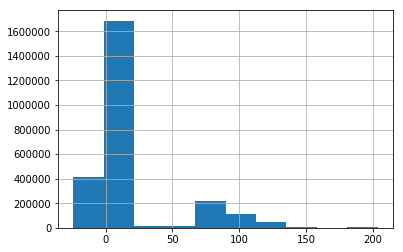

In [36]:
sub['scalar_coupling_constant'].hist()

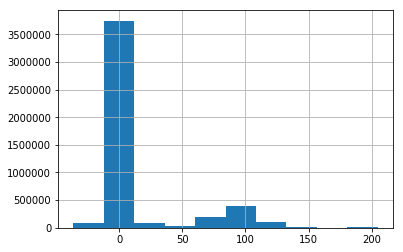

In [37]:
train['scalar_coupling_constant'].hist()

In [38]:
pd.DataFrame(oof).to_csv('oofs/validation_lgbm_v0.1.2.csv', index=False)
pd.DataFrame(predictions).to_csv('oofs/test_lgbm_v0.1.2.csv', index=False)